# Optimal allocation of effort

In [13]:
%matplotlib inline
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import copy
import random

import fortuna

In [14]:
def calc_dOdN(C,S):
    '''
    for the objective ln det C
    dOdC = C-1 = F
    dOdN = dOdC * dCdN, where dCdN = S (sensitivity tensor)
    '''
    F = np.linalg.pinv(C)
    dOdN = np.einsum('ij,ijkl->kl',F,S)
    return dOdN

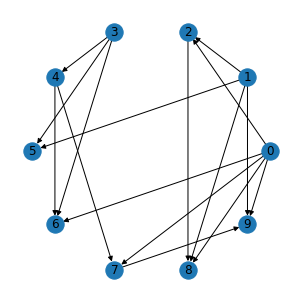

/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log
/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


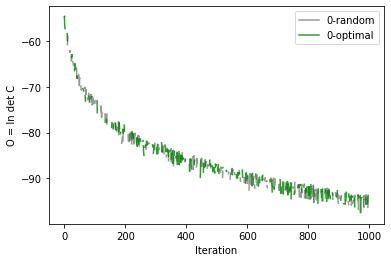

In [17]:
n_ligands = 10
repeats = 1
Nmax = 1000 # maximum number of iterations to simulate
# probability = 0.95 # probability threshold separating best and worst ligands for stopping the simulation

g = fortuna.graph.create_graph(n_ligands=n_ligands)
fortuna.graph.assign_uniform_weights(g)
fortuna.graph.realize_experiment(g)

#initialize everything
N0_ij = 10 * np.ones([n_ligands, n_ligands],dtype=int)

# calculate the fisher information matrix
F = fortuna.optimize.fisher_information_matrix(g, N0_ij)

# Compute the covariance matrix
labels = {}
for i in range(n_ligands):
    labels[i] = str(i)

plt.figure(figsize=(4,4))
nx.draw_circular(g,labels=labels)
plt.show()

score = np.zeros([Nmax])

color = {'random':'gray','optimal':'green'}
    
#calculate the 'real' free energies
f_i, C = fortuna.graph.mle(g,estimate=False) # compute free energy differences    
edges = [edge for edge in g.edges()]
indecies = [i for i in range(len(edges))]
for expt in ['random','optimal']:
    for repeat in range(repeats):
        fortuna.graph.reset_experiment(g,N0_ij)
        for step in range(Nmax):
            N_ij = fortuna.graph.form_edge_matrix(g, 'n_samples', action='symmetrize')
            s_ij = fortuna.graph.form_edge_matrix(g, 'statistical_fluctuation_est', action='symmetrize')

            C_ij = fortuna.optimize.estimate_correlation_matrix(s_ij, N_ij)
            f_i_est, C = fortuna.graph.mle(g,estimate=True) # compute free energy differences    

            score[step] = np.log(np.linalg.det(C_ij))
        
            if expt == 'random':
                for edge in g.edges():
                    g.edges[edge]['weight'] = 1 / len(edges)
                weights = [edge[2]['weight'] for edge in g.edges(data=True)]    
            elif expt == 'optimal':
                S = fortuna.optimize.sensitivity_tensor(g,N_ij)
                dO_dN = calc_dOdN(C_ij,S)
                w_ij = dO_dN / dO_dN.sum()    
                for edge in g.edges():
                    i,j = edge
                    g.edges[edge]['weight'] = w_ij[i,j]*2
                weights = [edge[2]['weight'] for edge in g.edges(data=True)]

            for index in np.random.choice(indecies,size=10,p=weights):
                chosen_edge = edges[index]
                g.edges[chosen_edge]['n_samples'] += 1
                samples = g.edges[chosen_edge]['samples'][0:g.edges[chosen_edge]['n_samples']]
                g.edges[chosen_edge]['f_ij_est'] = np.mean(samples)  
                g.edges[chosen_edge]['df_ij_est'] = np.std(samples) / np.sqrt(len(samples))
                g.edges[chosen_edge]['statistical_fluctuation_est'] = np.std(samples)
            
        plt.plot(score,'-',alpha=0.8,label=str(repeat)+'-'+str(expt),color=color[expt])
            
plt.xlabel('Iteration')
plt.ylabel('O = ln det C')
plt.legend()
plt.show()

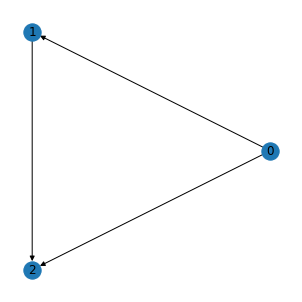

Sijkl
[[[[ 0.00000000e+00 -1.99940934e-02 -2.01336246e-02]
   [-1.99940934e-02  0.00000000e+00 -2.15788734e-02]
   [-2.01336246e-02 -2.15788734e-02  0.00000000e+00]]

  [[ 0.00000000e+00  6.63456974e-05  2.31251920e-04]
   [ 6.63456974e-05  0.00000000e+00  2.36178477e-04]
   [ 2.31251920e-04  2.36178477e-04  0.00000000e+00]]

  [[ 0.00000000e+00  6.27350487e-03  5.49883843e-03]
   [ 6.27350487e-03  0.00000000e+00  5.93727639e-03]
   [ 5.49883843e-03  5.93727639e-03  0.00000000e+00]]]


 [[[ 0.00000000e+00  6.63456974e-05  2.31251920e-04]
   [ 6.63456974e-05  0.00000000e+00  2.36178477e-04]
   [ 2.31251920e-04  2.36178477e-04  0.00000000e+00]]

  [[ 0.00000000e+00 -1.62162432e-02 -1.74946166e-02]
   [-1.62162432e-02  0.00000000e+00 -1.62356691e-02]
   [-1.74946166e-02 -1.62356691e-02  0.00000000e+00]]

  [[ 0.00000000e+00  3.58980921e-03  3.39308990e-03]
   [ 3.58980921e-03  0.00000000e+00  3.10150689e-03]
   [ 3.39308990e-03  3.10150689e-03  0.00000000e+00]]]


 [[[ 0.00000000e+00  6.2

/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


In [16]:
n_ligands = 3
repeats = 1
Nmax = 1 # maximum number of iterations to simulate
# probability = 0.95 # probability threshold separating best and worst ligands for stopping the simulation

g = fortuna.graph.create_graph(n_ligands=n_ligands)
fortuna.graph.assign_uniform_weights(g)
fortuna.graph.realize_experiment(g)

#initialize everything
N0_ij = 10 * np.ones([n_ligands, n_ligands],dtype=int)

# calculate the fisher information matrix
F = fortuna.optimize.fisher_information_matrix(g, N0_ij)

# Compute the covariance matrix
labels = {}
for i in range(n_ligands):
    labels[i] = str(i)

plt.figure(figsize=(4,4))
nx.draw_circular(g,labels=labels)
plt.show()

score = np.zeros([Nmax])

color = {'random':'gray','optimal':'green'}
    
#calculate the 'real' free energies
f_i, C = fortuna.graph.mle(g,estimate=False) # compute free energy differences    
edges = [edge for edge in g.edges()]
indecies = [i for i in range(len(edges))]
for expt in ['optimal']:
    for repeat in range(repeats):
        fortuna.graph.reset_experiment(g,N0_ij)
        for step in range(Nmax):
            N_ij = fortuna.graph.form_edge_matrix(g, 'n_samples', action='symmetrize')
            s_ij = fortuna.graph.form_edge_matrix(g, 'statistical_fluctuation_est', action='symmetrize')

            C_ij = fortuna.optimize.estimate_correlation_matrix(s_ij, N_ij)
            f_i_est, C = fortuna.graph.mle(g,estimate=True) # compute free energy differences    

            score[step] = np.log(np.linalg.det(C_ij))
        
            if expt == 'random':
                for edge in g.edges():
                    g.edges[edge]['weight'] = 1 / len(edges)
                weights = [edge[2]['weight'] for edge in g.edges(data=True)]    
            elif expt == 'optimal':
                S = fortuna.optimize.sensitivity_tensor(g,N_ij)
                print('Sijkl')
                print(S)
                print()
                dO_dN = calc_dOdN(C_ij,S)
                print('dOdN')
                print(dO_dN)
                print('dOdN is negative for all - sampling ANY edge is going to minimize the objective')
                print('the issue is that theyre all negative by ~ the same amount, so it doesnt really do anything to reallocate the effort')
                print()
                w_ij = dO_dN / dO_dN.sum()    
                for edge in g.edges():
                    i,j = edge
                    g.edges[edge]['weight'] = w_ij[i,j]*2
                weights = [edge[2]['weight'] for edge in g.edges(data=True)]

            for index in np.random.choice(indecies,size=10,p=weights):
                chosen_edge = edges[index]
                g.edges[chosen_edge]['n_samples'] += 1
                samples = g.edges[chosen_edge]['samples'][0:g.edges[chosen_edge]['n_samples']]
                g.edges[chosen_edge]['f_ij_est'] = np.mean(samples)  
                g.edges[chosen_edge]['df_ij_est'] = np.std(samples) / np.sqrt(len(samples))
                g.edges[chosen_edge]['statistical_fluctuation_est'] = np.std(samples)
